In [1]:
import tensorflow as tf
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import shap  # SHAP library
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Configuración de hiperparámetros
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
DATASET_DIR = "arcgis-survey-images"
SEED = 123

In [3]:
# Cargar el conjunto de datos
def load_dataset(dataset_dir, image_size, batch_size, validation_split, subset, seed):
    return tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        image_size=image_size,
        validation_split=validation_split,
        subset=subset,
        seed=seed,
        batch_size=batch_size
    )

train_ds = load_dataset(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, validation_split=0.2, subset='training', seed=SEED)
validation_ds = load_dataset(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, validation_split=0.2, subset='validation', seed=SEED)

Found 3289 files belonging to 5 classes.
Using 2632 files for training.
Found 3289 files belonging to 5 classes.
Using 657 files for validation.


In [4]:
# Preprocesar los datos
def preprocess_dataset(dataset):
    X, y = [], []
    for images, labels in dataset:
        X.append(images.numpy())
        y.append(labels.numpy())
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

X_train, y_train = preprocess_dataset(train_ds)
X_val, y_val = preprocess_dataset(validation_ds)

In [5]:
# Aplanar las imágenes para usar con Árbol de Decisión
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

In [6]:
# División adicional del conjunto de validación para crear un conjunto de prueba
X_val_flat, X_test_flat, y_val, y_test = train_test_split(X_val_flat, y_val, test_size=0.5, random_state=SEED)

In [7]:
# Entrenar un Árbol de Decisión
tree_model = DecisionTreeClassifier(random_state=SEED)
tree_model.fit(X_train_flat, y_train)

DecisionTreeClassifier(random_state=123)

In [8]:
# Evaluar el modelo en el conjunto de validación
y_pred_tree_val = tree_model.predict(X_val_flat)
print("Reporte de clasificación para el conjunto de validación:")
print(classification_report(y_val, y_pred_tree_val))

Reporte de clasificación para el conjunto de validación:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48        73
           1       0.24      0.28      0.26        40
           2       0.45      0.41      0.43        83
           3       0.57      0.61      0.59       109
           4       0.05      0.04      0.05        23

    accuracy                           0.45       328
   macro avg       0.36      0.36      0.36       328
weighted avg       0.44      0.45      0.44       328



In [9]:
# Evaluar el modelo en el conjunto de prueba
y_pred_tree_test = tree_model.predict(X_test_flat)
print("Reporte de clasificación para el conjunto de prueba:")
print(classification_report(y_test, y_pred_tree_test))

Reporte de clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.54      0.44      0.48        91
           1       0.23      0.24      0.23        37
           2       0.49      0.44      0.47        90
           3       0.45      0.56      0.50        93
           4       0.11      0.11      0.11        18

    accuracy                           0.43       329
   macro avg       0.36      0.36      0.36       329
weighted avg       0.44      0.43      0.44       329



In [10]:
# SHAP para Árboles de Decisión
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_val_flat[:5])

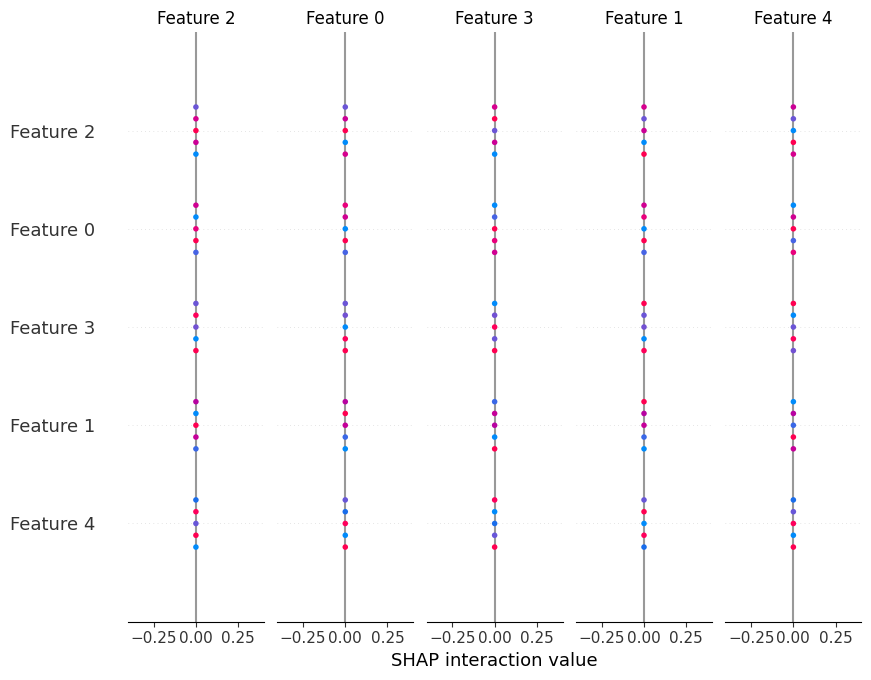

In [11]:
# Graficar los valores SHAP
shap.summary_plot(shap_values, X_val_flat[:5])

<Figure size 1000x800 with 0 Axes>

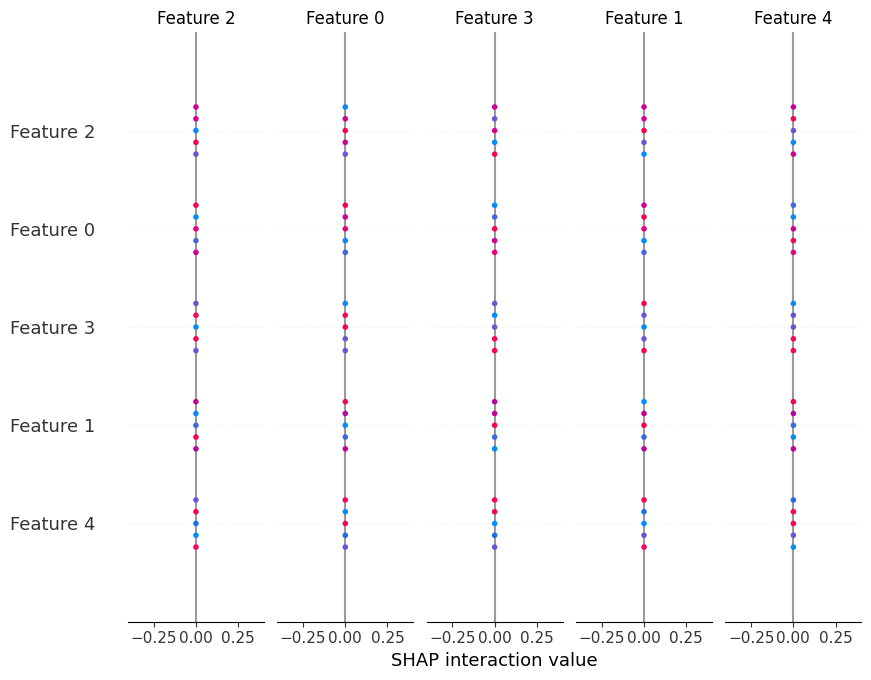

In [12]:

# Graficar la importancia de las características
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val_flat[:5], plot_type="bar")
plt.show()
